In [1]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install transformers==4.2.2 datasets einops

In [4]:
device = "cpu"

In [13]:
import datasets
import torch
import torch.nn as nn
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import jax
import jax.numpy as jnp
import functools
import numpy as np
import tqdm
import pathlib
from collections import namedtuple
import collections
import seaborn as sns

from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoTokenizer
from transformers import AutoConfig, AutoModel, AutoTokenizer

from utils import l1_matrix_norm, linf_matrix_norm, composite_norm, all_norms, all_norms_names
from surgery import NoSkipBertSelfOutput, BertIntermediateId, BertOutputId, BertOutputNoSkip, AlbertAttentionWithoutSkipConnection, TransformerBlockWithoutSkip
from utils import sample_P_matrix, compute_low_rank

## Load Data

In [6]:
dataset = datasets.load_dataset("wiki_bio", split="test")

Using custom data configuration default
Reusing dataset wiki_bio (/Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f)


In [7]:
# Process the dataset - tokenize the context texts (using a tokenizer from the 🤗 transformers library)

def first_batch(model_name):

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


    def encode(examples):
        return tokenizer(examples['target_text'], truncation=True, padding='max_length', max_length=128)

    tokenized_dataset = dataset.map(encode, batched=True)

    # keep only sentences > 128 tokens
    long_dataset = tokenized_dataset.filter(lambda x: bool(sum(x["attention_mask"]) >= 128))

    # to PyTorch
    long_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask']) # 'token_type_ids', 
    dataloader = torch.utils.data.DataLoader(long_dataset, batch_size=32)

    # take first batch
    batch = next(iter(dataloader))

    return batch


first_batchs = {}

for model_name in ['bert-base-cased']:#, 'albert-base-v2', 'distilbert-base-uncased']:
    print(f"process batch for {model_name}")
    first_batchs[model_name] =  first_batch(model_name)

process batch for bert-base-cased


Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-d706949916fd7e1c.arrow
Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-168b6cf50422f7dc.arrow
/Users/user/anaconda3/lib/python3.7/site-packages/datasets/arrow_dataset.py:851: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370126481/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.ten

## Create Model

In [8]:
model_name = 'bert-base-cased'
pretrained = True
config = AutoConfig.from_pretrained(model_name)

if pretrained:
    model = AutoModel.from_pretrained(model_name)
else:
    model = AutoModel.from_config(config)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval();

In [9]:
batch = first_batchs[model_name]


In [10]:
# forward pass to compute the attention probs
with torch.no_grad():
    output = model(**batch, output_attentions=True, output_hidden_states=True)

# Inference function

In [14]:
def inference(model_name, pretrained: bool, remove_attn_skip: bool, 
              remove_ffn: bool, device="cpu"):
    # -- data
    batch = first_batch(model_name)

    # -- model
    config = AutoConfig.from_pretrained(model_name)
    if pretrained:
        model = AutoModel.from_pretrained(model_name)
    else:
        model = AutoModel.from_config(config)
    model = model.to(device)

    # -- remove skip connection
    if remove_attn_skip:
        if model_name == "distilbert-base-cased":
            for i in range(6):
                original = model.transformer.layer[0]
                new_layer = TransformerBlockWithoutSkip(config)
                device = next(original.parameters()).device
                new_layer = new_layer.to(device)
                model.transformer.layer[0] = new_layer
                new_layer.load_state_dict(original.state_dict())
        elif model_name == "albert-base-v2":
            original = model.encoder.albert_layer_groups[0].albert_layers[0].attention 
            new_layer = AlbertAttentionWithoutSkipConnection(config)
            device = next(original.parameters()).device
            new_layer = new_layer.to(device)
            model.encoder.albert_layer_groups[0].albert_layers[0].attention = new_layer
            new_layer.load_state_dict(original.state_dict())
        elif model_name == "bert-base-cased":
            config = model.config
            num_layers = config.num_hidden_layers
            with torch.no_grad():
                for layer_idx in range(num_layers):
                    original = model.encoder.layer[layer_idx].attention.output
                    new_layer = NoSkipBertSelfOutput(config)
                    device = next(original.parameters()).device
                    new_layer = new_layer.to(device)
                    model.encoder.layer[layer_idx].attention.output = new_layer
                    new_layer.load_state_dict(original.state_dict())
        elif model_name == "xlnet-base-cased":
            for i in range(12):
                model.layer[i].rel_attn.post_attention = functools.partial(model.layer[i].rel_attn.post_attention, residual=False)
        else:
            raise Exception(f"Unknown model {model_name}")
    
    if remove_ffn:
        if model_name == "bert-base-cased":
            config = model.config
            num_layers = config.num_hidden_layers
            with torch.no_grad():
                for layer_idx in range(num_layers):
                    model.encoder.layer[layer_idx].intermediate = BertIntermediateId()
                    model.encoder.layer[layer_idx].output = BertOutputId()
        elif model_name == "albert-base-v2":
            model.encoder.albert_layer_groups[0].albert_layers[0].ffn = nn.Identity()
            model.encoder.albert_layer_groups[0].albert_layers[0].ffn_output = nn.Identity()
        elif model_name == "xlnet-base-cased":
            for i in range(12):
                model.layer[i].ff = nn.Identity()
            
        else:
            raise Exception("Unknown model")


    model.eval();
    batch = {k: v.to(device) for k, v in batch.items()}
    output = model(**batch, output_attentions=True, output_hidden_states=True)
    return output

# output = inference("bert-base-cased", True, True, True)
# output = inference("albert-base-v2", True, True, True)
output = inference("xlnet-base-cased", True, True, True)

Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-e3d724b10a07d0bb.arrow
Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-3eb8d459662804e2.arrow


# Compute outputs for all models (save to disk)

In [16]:
R = namedtuple("R", "hidden_states attentions")

pathlib.Path("models/").mkdir(parents=True, exist_ok=True)

for model_name in ["bert-base-cased", "albert-base-v2", "xlnet-base-cased"]:
    for pretrained in [True, False]:
        for remove_attn_skip in [True, False]:
            for remove_ffn in [True, False]:
                filename = f"models/{model_name}_pretrained={pretrained}_remove_attn_skip={remove_attn_skip}_remove_ffn={remove_ffn}.pt"
                if not pathlib.Path(filename).exists():
                    output = inference(model_name, pretrained=pretrained, remove_attn_skip=remove_attn_skip, remove_ffn=remove_ffn)
                    output = R(output.hidden_states, output.attentions)
                    torch.save(output, filename)
                    del output

# Plot residual function

In [17]:
def plot_residual(ratios, aggregate="all", c="C0", ax=None, **kwargs):
    num_layers, num_samples = ratios.shape[:2]

    if aggregate == "all":
        for sample_idx in range(num_samples):
            ax.plot(np.arange(num_layers), ratios[:, sample_idx],
                    c=c, alpha=.1, **kwargs)# ax=ax)

    mean_value = ratios.mean(axis=-1)
    std_value = ratios.std(axis=-1)

    ax.plot(np.arange(num_layers), mean_value,
                c=c, **kwargs)#, ax=ax)

    if aggregate == "std":
        ax.fill_between(np.arange(num_layers), mean_value - std_value, mean_value + std_value,
                         color=c, alpha=.2)

    plt.xlabel(f"layer index")
    plt.ylim([0 - 0.01, 1 + 0.01])
    plt.grid(alpha=.3)

load filename models/xlnet-base-cased_pretrained=True_remove_attn_skip=True_remove_ffn=True.pt
load filename models/xlnet-base-cased_pretrained=True_remove_attn_skip=True_remove_ffn=False.pt
load filename models/xlnet-base-cased_pretrained=True_remove_attn_skip=False_remove_ffn=True.pt
load filename models/xlnet-base-cased_pretrained=True_remove_attn_skip=False_remove_ffn=False.pt
load filename models/xlnet-base-cased_pretrained=False_remove_attn_skip=True_remove_ffn=True.pt
load filename models/xlnet-base-cased_pretrained=False_remove_attn_skip=True_remove_ffn=False.pt
load filename models/xlnet-base-cased_pretrained=False_remove_attn_skip=False_remove_ffn=True.pt
load filename models/xlnet-base-cased_pretrained=False_remove_attn_skip=False_remove_ffn=False.pt
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `figures/residual_XLNet_vert_croped.pdf'.


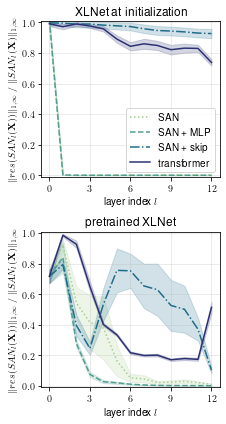

In [23]:

# ====== CHANGE THESE LINES TO CREATE THE 3 PLOTS ======== #
# model_name, model_nickname = "bert-base-cased", "BERT"
# model_name, model_nickname = "albert-base-v2", "Albert"
model_name, model_nickname = "xlnet-base-cased", "XLNet"
# ======================================================== #

pathlib.Path("figures/").mkdir(parents=True, exist_ok=True)

num_repeats = 100
vertical = True

if vertical:
    fig, axes = plt.subplots(2, 1)
else:
    fig, axes = plt.subplots(1, 2)
norm_fn = all_norms["l1 * l_inf"]


cmap = plt.cm.get_cmap("crest", 4)
colors = collections.defaultdict(lambda: cmap(len(colors)))
lss = collections.defaultdict(lambda: ["-", ":", "--", "-."][len(lss)])

Record = namedtuple("Record", "model_name remove_attn_skip remove_ffn pretrained label ls c")

lines = [
    r for p in [True, False] for r in [
    Record(model_name, True, True, p, "SAN", ":", cmap(0)),
    Record(model_name, True, False, p, "SAN + MLP", "--", cmap(1)),
    Record(model_name, False, True, p, "SAN + skip", "-.", cmap(2)),
    Record(model_name, False, False, p, "transformer", "-", cmap(3))
    ] 
]

for line in lines:
    filename = f"models/{line.model_name}_pretrained={line.pretrained}_remove_attn_skip={line.remove_attn_skip}_remove_ffn={line.remove_ffn}.pt"
    print("load filename", filename)
    output = torch.load(filename)

    # plotting output residual
    hidden_states = torch.stack(output.hidden_states).cpu().detach()
    
    if False:
        rank_one = jax.vmap(jax.vmap(functools.partial(compute_low_rank, k=1)))(jnp.array(hidden_states))
        rank_one = torch.tensor(np.array(rank_one))
        residuals = hidden_states - rank_one
    else:
        residuals = hidden_states - hidden_states.mean(dim=-2, keepdim=True)
    
    
    ratio = norm_fn(residuals) / norm_fn(hidden_states)

    ax = axes[0 if not line.pretrained else 1]
    plt.sca(ax)
    plot_residual(ratio, aggregate="std", ax=ax, label=line.label, ls=line.ls, c=line.c)


fig.axes[0 if vertical else 1].legend()
for ax in fig.axes:
    ax.set_xticks([0, 3, 6, 9, 12])
    ax.set_xlabel("layer index $l$")
    
fig.axes[0].set_title(f"{model_nickname} at initialization")
fig.axes[1].set_title(f"pretrained {model_nickname}")
# fig.axes[0].set_ylabel(r"\|\operatorname{res}(\operatorname{SAN}_l(\mathbf{X}))||~/~||\operatorname{SAN}_l(\mathbf{X})||")
fig.axes[0].set_ylabel(r'$\|res(SAN_l(\mathbf{X}))\|_{1, \infty} ~ / ~ \|SAN_l(\mathbf{X})\|_{1, \infty}$')
if vertical:
    fig.axes[1].set_ylabel(r'$\|res(SAN_l(\mathbf{X}))\|_{1, \infty} ~ / ~ \|SAN_l(\mathbf{X})\|_{1, \infty}$')


if vertical:
    fig.set_size_inches(3.25, 6)
else:
    fig.set_size_inches(6, 3.25)

filename = f"figures/residual_{model_nickname}{'_vert' if vertical else ''}"
plt.tight_layout()
fig.savefig(f"{filename}.pdf")

!pdfcrop {filename}.pdf {filename}_croped.pdf

In [25]:
results = []
num_repeats = 100
norm_fn = all_norms["l1 * l_inf"]

model_name = "bert-base-cased"

for pretrained in [True, False]:
    remove_attn_skip = False
    output = inference(model_name, pretrained=pretrained, remove_attn_skip=remove_attn_skip, remove_ffn=False)
    attentions = torch.stack(output.attentions, axis=0)
    # layers, batch, heads, seq, seq
    attentions.shape
    for depth in range(1, 13):
        for repeat in range(num_repeats):
            P = sample_P_matrix(attentions, depth).detach()
            rank_one = compute_low_rank(jnp.array(P), k=1)
            rank_one = torch.tensor(np.array(rank_one))
            residuals = P - rank_one
            ratio = norm_fn(residuals) / norm_fn(P)
            results.append({"depth": depth,
                            "ratio": ratio.item(),
                            "model": ("pretrained" if pretrained else "init") + (" w/o skip" if remove_attn_skip else "")})
    del output, attentions, P


Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-d706949916fd7e1c.arrow
Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-168b6cf50422f7dc.arrow
Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-d706949916fd7e1c.arrow
Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/wiki_bio/default/1.1.0/50f08e9f9fbdd880ef68b0af24b3800bf2735e1721910a1aee95ff7c8c4b6f1f/cache-168b6cf50422f7dc.arrow


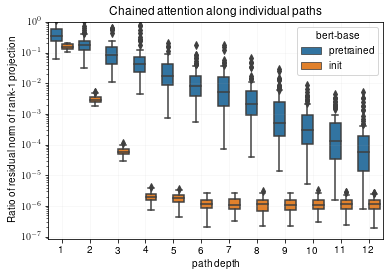

In [31]:
df = pd.DataFrame(results)
sns.boxplot(data=df, x="depth", y="ratio", hue="model")
plt.yscale("log")
plt.ylim([None, 1.])
plt.grid(alpha=.1)
plt.ylabel("Ratio of residual norm of rank-1 projection")
plt.xlabel("path depth")
plt.title("Chained attention along individual paths")
plt.legend(title="bert-base")
plt.show()